# An Exploratory Analysis of Movie Industry Data from IMBD and Rotten Tomatoes

<b>Author:</b> Avonlea Fisher

<b>Blog post URL:</b> https://medium.com/@avfisher/an-exploratory-analysis-of-movie-industry-data-from-imbd-and-rotten-tomatoes-fcbf0bf6924c

# Introduction

This project explores movie industry data to determine which types of movies have been most successful. The hypothetical context for this analysis is that Microsoft is interested in creating and selling original video content. The company has hired a team of analysts to inform their decisions about the types of films it should be creating. The project will consist of an analytical component, visualizations, and a presentation of the findings for non-technical audiences.

# Questions

The analysis will aim to address three questions about the movie industry:
1. What types of movies (genre and content rating) are the most popular?
2. What are the highest-grossing movie genres?
3. What is the ideal range for movie runtimes, in terms of profitability? 

# Data Description

### IMBD
The analysis explores a merged form of two IMBD datasets: one which contains data on domestic and foreign grossses, and one with data on runtimes and genres. 

### Rotten Tomatoes
To address the question about movie popularity, the IMBD data is supplemented with two datasets from Rotten Tomatoes, which contain data on movie ratings and reviews.

# Data Cleaning

## IMBD Data 
We will use <b>pandas</b> to read, clean, and format the IMBD data into a workable dataframe. Let's read and preview the movie gross dataset:

In [1]:
import pandas as pd
Movie_Gross = pd.read_csv('bom.movie_gross.csv.gz', nrows=100000, compression='gzip',
                   error_bad_lines=False)
Movie_Gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Now let's preview the other dataset:

In [2]:
IMBD_Basics = pd.read_csv('imdb.title.basics.csv.gz', nrows=1000000, compression='gzip',error_bad_lines=False)
IMBD_Basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Both datasets have a column for the name of individual movies. We can start by merging the datasets along this column, and later account for any set of different movies that share the same title. Below, we generate a list of common titles by looping through unique titles in one dataset and finding matches in the other. 

Note: since the purpose of this step is only to show that there are many common titles, we're only looping through the first 1000 rows. Looping through the whole dataset would take a long time!

In [3]:
Common_titles = []
for title in IMBD_Basics['primary_title'][0:1000].unique(): 
    if title in Movie_Gross['title'][0:1000].unique():
        Common_titles.append(title)

In [4]:
print(Common_titles[0:10])
len(Common_titles)

['On the Road', 'The Rum Diary', 'The Three Stooges', 'Tangled', 'John Carter', 'Cowboys & Aliens', 'Dinner for Schmucks', 'The A-Team', 'The Possession', 'Real Steel']


90

The above output shows us that merging on common titles would still leave us with a large number of datapoints for our analysis. We'll use <code>df.merge</code> to join the datasets along rows with matching titles.

In [5]:
IMBD_df = Movie_Gross.merge(IMBD_Basics, how='inner', left_on='title', right_on='primary_title')
IMBD_df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy"
1,Inception,WB,292600000.0,535700000,2010,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,P/DW,238700000.0,513900000,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy"
4,Iron Man 2,Par.,312400000.0,311500000,2010,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi"


Now we can drop some of the superfluous columns that won't be relevant for our analysis.

In [6]:
IMBD_df = IMBD_df.drop(columns=['primary_title', 'original_title', 'tconst', 'studio'])

By inspecting the first 40 rows of the dataframe, we find that there are some repeated titles. The 'year' and 'start_year' columns for many of these repeats have different values, which suggests that many repeats are different movies have the same name. We want the final dataframe to contain only those rows with values that all correspond to the same movie, so our next step is to filter out movies with mismatched years.

In [7]:
IMBD_df.head(41)

,title,domestic_gross,foreign_gross,year,start_year,runtime_minutes,genres
0,Toy Story 3,415000000.0,652000000,2010,2010,103.0,"Adventure,Animation,Comedy"
1,Inception,292600000.0,535700000,2010,2010,148.0,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,238700000.0,513900000,2010,2010,93.0,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,300500000.0,398000000,2010,2010,124.0,"Adventure,Drama,Fantasy"
4,Iron Man 2,312400000.0,311500000,2010,2010,124.0,"Action,Adventure,Sci-Fi"
5,Tangled,200800000.0,391000000,2010,2010,100.0,"Adventure,Animation,Comedy"
6,Despicable Me,251500000.0,291600000,2010,2010,95.0,"Animation,Comedy,Family"
7,How to Train Your Dragon,217600000.0,277300000,2010,2010,98.0,"Action,Adventure,Animation"
8,The Chronicles of Narnia: The Voyage of the Da...,104400000.0,311300000,2010,2010,113.0,"Adventure,Family,Fantasy"
9,The King's Speech,135500000.0,275400000,2010,2010,118.0,"Biography,Drama,History"


What is the length of this dataframe?

In [8]:
len(IMBD_df)

3366

Using this length as the upper end of our index range, we can now identify rows where the years do not match and drop those rows.

In [9]:
for i in range(0,3366):
    if IMBD_df['year'][i] != IMBD_df['start_year'][i]:
        IMBD_df.drop(i, inplace = True)

If two different movies have both the same title and the same year, they will still be present as mismatches in the dataframe. However, it's safe to assume that such cases are so rare that they will have a negligible impact on the analysis.

In [10]:
len(IMBD_df)

1873

The length of our dataframe is now 1873. Still not a bad sample size! The next step in the cleaning process is to find and deal with any missing values. By chaining the sum method to isna(), we get the total missing values for each column in the dataframe:

In [11]:
IMBD_df.isna().sum()

title                0
domestic_gross      10
foreign_gross      595
year                 0
start_year           0
runtime_minutes     10
genres               2
dtype: int64

There are 595 missing values in the foreign_gross column. We cannot eliminate the entire row wherever there is a missing value, since doing so would require discarding valuable data in other colums with far fewer missing values. Instead, we can drop the foreign gross column, and then drop the few remaining rows that have missing values for other columns. Although this approach will cost us the data on foreign markets, it will give us a better picture of which types of movies perform well in domestic markets.

In [12]:
IMBD_df = IMBD_df.drop(columns = 'foreign_gross')

In [13]:
IMBD_df = IMBD_df.dropna()

In [14]:
#confirm that no missing values remain
IMBD_df.isna().sum()

title              0
domestic_gross     0
year               0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

In [15]:
#get final length
len(IMBD_df)

1852

## Rotten Tomatoes Data

We'll use the same approach to read and clean the Rotten Tomatoes dataset.

In [16]:
rt_reviews = pd.read_csv('rt.reviews.tsv', delimiter="\t", header=0, encoding="unicode_escape'")
rt_reviews.head(100000)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [17]:
rt_info = pd.read_csv('rt.movie_info.tsv', delimiter = '\t', header=0, encoding="unicode_escape")
rt_info.head() 

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


The only column that these datasets have in common is "id." Before merging on this column, we should confirm that these id numbers correspond to the same movie in both datasets. There's no column for the movie titles, so we'll have to inspect the reviews column to get a title.

In [18]:
#changes column display settings to display entire cell content when inspecting reviews 
pd.set_option('display.max_colwidth', None)

#display first five rows
rt_reviews['review'][0:5]

0                                                                      A distinctly gallows take on contemporary financial mores, as one absurdly rich man's limo ride across town for a haircut functions as a state-of-the-nation discourse. 
1                                                                                                                                        It's an allegory in search of a meaning that never arrives...It's just old-fashioned bad storytelling.
2      ... life lived in a bubble in financial dealings and digital communications and brief face-to-face conversations and sexual intermissions in a space shuttle of a limousine creeping through the gridlock of an anonymous New York City.
3    Continuing along a line introduced in last year's "A Dangerous Method", David Cronenberg pushes his cinema towards a talky abstraction in his uncanny, perversely funny and frighteningly insular adaptation of Don DeLillo, "Cosmopolis".
4                                       

It appears that id #3 in the reviews dataset corresponds to *Cosmopolis* by director David Cronenberg. Let's inspect the same id number for the movie info dataset.

In [19]:
rt_info.loc[1]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      3
synopsis        New York City, not-too-distant-future: Eric Packer, a 28 year-

We have a match! A quick Google search will confirm that all of these values match the information for *Cosmopolis*. To ensure that this match isn't coincidental, we'll test another ID number chosen at random.

In [20]:
#get ID number for another sequence of rows
rt_reviews['id'][800:805]

800    23
801    23
802    23
803    23
804    23
Name: id, dtype: int64

In [21]:
rt_reviews['review'][800:805]

800                                                                    Regardless of its fine cast and stylish execution, the shallow "American Hustle" sells sparkle and hustle. 
801           American Hustle offers a, crowd-pleasing experience - one with profound social commentary, laugh-out-loud comedy, and even unexpected moments of compassion to boot.
802                                                    The most exciting thing about David O. Russell's operatic-comedy American Hustle is how every piece of it double plays us. 
803                       The ensemble helps to spotlight virtues in those who are flawed, and flaws in those who are virtuous, earning sympathy where sometimes none is deserved.
804    On paper, American Hustle should be the movie of the year and sweep the Oscars, but its supreme promise fades once the lights go down in the theater. It's good, not great.
Name: review, dtype: object

In the reviews dataset, ID #23 corresponds to *American Hustle*. What about the info dataset?

In [22]:
test = rt_info.loc[rt_info['id'] == 23]

Another match! Now that we know that the IDs in both datasets correspond to the same films, and can merge them on this column. We'll specify <code>how='inner'</code> to only extract rows with matching id numbers in both datasets.

In [23]:
RT_df = rt_info.merge(rt_reviews, how='inner', on='id')
RT_df.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Packer, a 28 year-old finance golden boy dreaming of living in a civilization ahead of this one, watches a dark shadow cast over the firmament of the Wall Street galaxy, of which he is the uncontested king. As he is chauffeured across midtown Manhattan to get a haircut at his father's old barber, his anxious eyes are glued to the yuan's exchange rate: it is mounting against all expectations, destroying Eric's bet against it. Eric Packer is losing his empire with every tick of the clock. Meanwhile, an eruption of wild activity unfolds in the city's streets. Petrified as the threats of the real world infringe upon his cloud of virtual convictions, his paranoia intensifies during the course of his 24-hour cross-town odyssey. Packer starts to piece together clues that lead him to a most terrifying secret: his imminent assassination. -- (C) Official Site",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,"A distinctly gallows take on contemporary financial mores, as one absurdly rich man's limo ride across town for a haircut functions as a state-of-the-nation discourse.",3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,"New York City, not-too-distant-future: Eric Packer, a 28 year-old finance golden boy dreaming of living in a civilization ahead of this one, watches a dark shadow cast over the firmament of the Wall Street galaxy, of which he is the uncontested king. As he is chauffeured across midtown Manhattan to get a haircut at his father's old barber, his anxious eyes are glued to the yuan's exchange rate: it is mounting against all expectations, destroying Eric's bet against it. Eric Packer is losing his empire with every tick of the clock. Meanwhile, an eruption of wild activity unfolds in the city's streets. Petrified as the threats of the real world infringe upon his cloud of virtual convictions, his paranoia intensifies during the course of his 24-hour cross-town odyssey. Packer starts to piece together clues that lead him to a most terrifying secret: his imminent assassination. -- (C) Official Site",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that never arrives...It's just old-fashioned bad storytelling.,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,"New York City, not-too-distant-future: Eric Packer, a 28 year-old finance golden boy dreaming of living in a civilization ahead of this one, watches a dark shadow cast over the firmament of the Wall Street galaxy, of which he is the uncontested king. As he is chauffeured across midtown Manhattan to get a haircut at his father's old barber, his anxious eyes are glued to the yuan's exchange rate: it is mounting against all expectations, destroying Eric's bet against it. Eric Packer is losing his empire with every tick of the clock. Meanwhile, an eruption of wild activity unfolds in the city's streets. Petrified as the threats of the real world infringe upon his cloud of virtual convictions, his paranoia intensifies during the course of his 24-hour cross-town odyssey. Packer starts to piece together clues that lead him to a most terrifying secret: his imminent assassination. -- (C) Official Site",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealings and digital communications and brief face-to-face conversations and sexual intermissions in a space shuttle of a limousine creeping through the gridlock of an anonymous New York City.,NaN,fresh,Sean Axmaker,0,Stream o

Notice that there are two new columns: rating_x and rating_y. This is because both datasets contained a rating column, but for different types of ratings. We're only interested in the content rating, or 'rating_x', as we'll be using the 'fresh' column for data on movie reviews.

We can use the <b>pandasql</b> package to easily create a subsetted dataframe with only the rating and review information.

In [24]:
from pandasql import sqldf

#helper function to specify global variables for every query
pysqldf = lambda q: sqldf(q, globals())

#select relevant columns and overwrite RT_df
q = """select id, rating_x, review, fresh from RT_df;"""
RT_df = pysqldf(q)
RT_df.head()

,id,rating_x,review,fresh
0,3,R,"A distinctly gallows take on contemporary financial mores, as one absurdly rich man's limo ride across town for a haircut functions as a state-of-the-nation discourse.",fresh
1,3,R,It's an allegory in search of a meaning that never arrives...It's just old-fashioned bad storytelling.,rotten
2,3,R,... life lived in a bubble in financial dealings and digital communications and brief face-to-face conversations and sexual intermissions in a space shuttle of a limousine creeping through the gridlock of an anonymous New York City.,fresh
3,3,R,"Continuing along a line introduced in last year's ""A Dangerous Method"", David Cronenberg pushes his cinema towards a talky abstraction in his uncanny, perversely funny and frighteningly insular adaptation of Don DeLillo, ""Cosmopolis"".",fresh
4,3,R,... a perverse twist on neorealism...,fresh


Finally, we'll want to organize this data by the frequency of 'fresh' and 'rotten' values for each movie rating. On Rotten Tomatoes, a positively reviewed film is given the status of 'fresh', while a negatively reviewed film is 'rotten.' In the analysis section, we can compare the frequency of these values for each content rating as a measure of popularity.

The below function takes the rating as an input, creates a frequency dictionary for that rating, and updates the 'fresh' and 'rotten' values each time one of these values occurs in a RT_df row:

In [25]:
def create_freshness_dict(rating):
    rating_dict = {'rating': rating, 'Fresh': 0, 'Rotten': 0}
    for i in range(len(RT_df)):
        if RT_df['rating_x'][i] == rating and RT_df['fresh'][i] == 'fresh':
            rating_dict['Fresh'] += 1
        elif RT_df['rating_x'][i] == rating and RT_df['fresh'][i] == 'rotten':
            rating_dict['Rotten'] += 1
    return rating_dict

In [26]:
#create list of rating types
Rating_Types = ['R', 'PG', 'PG-13', 'G', 'NR']

In [27]:
#Using the above list and a for loop, apply the function to every content rating, 
#and store it in a list of dictionaries.

RT_Fresh = []
for r in Rating_Types:
    RT_Fresh.append(create_freshness_dict(r))
RT_Fresh

[{'rating': 'R', 'Fresh': 15561, 'Rotten': 8810},
 {'rating': 'PG', 'Fresh': 5286, 'Rotten': 2960},
 {'rating': 'PG-13', 'Fresh': 9303, 'Rotten': 8705},
 {'rating': 'G', 'Fresh': 774, 'Rotten': 297},
 {'rating': 'NR', 'Fresh': 2045, 'Rotten': 605}]

# Analysis 

### Question 1: What types of movies are the most popular?

To answer this question, we'll look at data on both movie genres (IMBD) and movie content ratings (Rotten Tomatoes). We'll use genre frequency and freshness ratings, respectively, as measures of popularity. Let's begin by exploring the IMBD data. 

#### IMBD: What are the most common movie genres?
This sub-question assumes that other companies produce more of the types of movies that they have been found to be most popular, which will be useful knowledge for determing which types of movies our company should create.  The question can be answered by using data from the genre column to get information about the prevalence of individual genres. As it stands, most rows contain a combination of multiple genres, which results in a large number of unique values:

In [28]:
len(IMBD_df['genres'].unique())

262

We want to reorganize these genre combinations into data on individual genres, the count for which we can expect to be much lower. Let's start by making an empty list and populating it with unique genres.

In [29]:
#Create empty genres list
genres = []

#loop through genres column
for row in IMBD_df['genres']:
    #convert string in each row to a list of genres
    row_list =  str(row).strip().split(',')
    #loop through each row's list of genres and populate the genres list created in the cell's first line
    for genre in row_list:
        if genre not in genres:
            genres.append(genre)

In [30]:
print(genres)
print(len(genres))

['Adventure', 'Animation', 'Comedy', 'Action', 'Sci-Fi', 'Drama', 'Fantasy', 'Family', 'Biography', 'History', 'Thriller', 'Romance', 'Horror', 'Mystery', 'Western', 'Crime', 'Sport', 'War', 'Music', 'Musical', 'Documentary', 'News']
22


There were 262 genre combinations, but only 22 unique genres. This is a much easier number to work with. Now let's make a list of the frequencies for each genre.

In [31]:
#create frequency dictionary 
genre_freqs = {}

#import operator module for sorting dictionary items by value counts
import operator

#loop through genres list
for genre in genres:
    genre_freqs[genre] = 0
    #update frequency dictionary with frequencies for each genre
    for row in IMBD_df['genres']:
        row_list =  str(row).strip().split(',')
        if genre in row_list:
            genre_freqs[genre] += 1
            
#sort frequency dictionary by values
sorted_genres = dict(sorted(genre_freqs.items(), key=operator.itemgetter(1), reverse=True))
sorted_genres

{'Drama': 959,
 'Comedy': 654,
 'Action': 520,
 'Adventure': 362,
 'Romance': 300,
 'Thriller': 286,
 'Crime': 267,
 'Biography': 191,
 'Horror': 145,
 'Mystery': 131,
 'Fantasy': 123,
 'Animation': 114,
 'Documentary': 110,
 'Sci-Fi': 108,
 'Family': 81,
 'History': 74,
 'Music': 61,
 'Sport': 35,
 'War': 23,
 'Musical': 12,
 'Western': 11,
 'News': 1}

Time to plot these frequencies! The first step is to assign the frequencies to the values that will be plotted on the y axis, and the genres to the x-axis values.

In [32]:
x = list(sorted_genres.keys())
y = list(sorted_genres.values())

We'll use <b>matplotlib</b> to plot the frequencies:

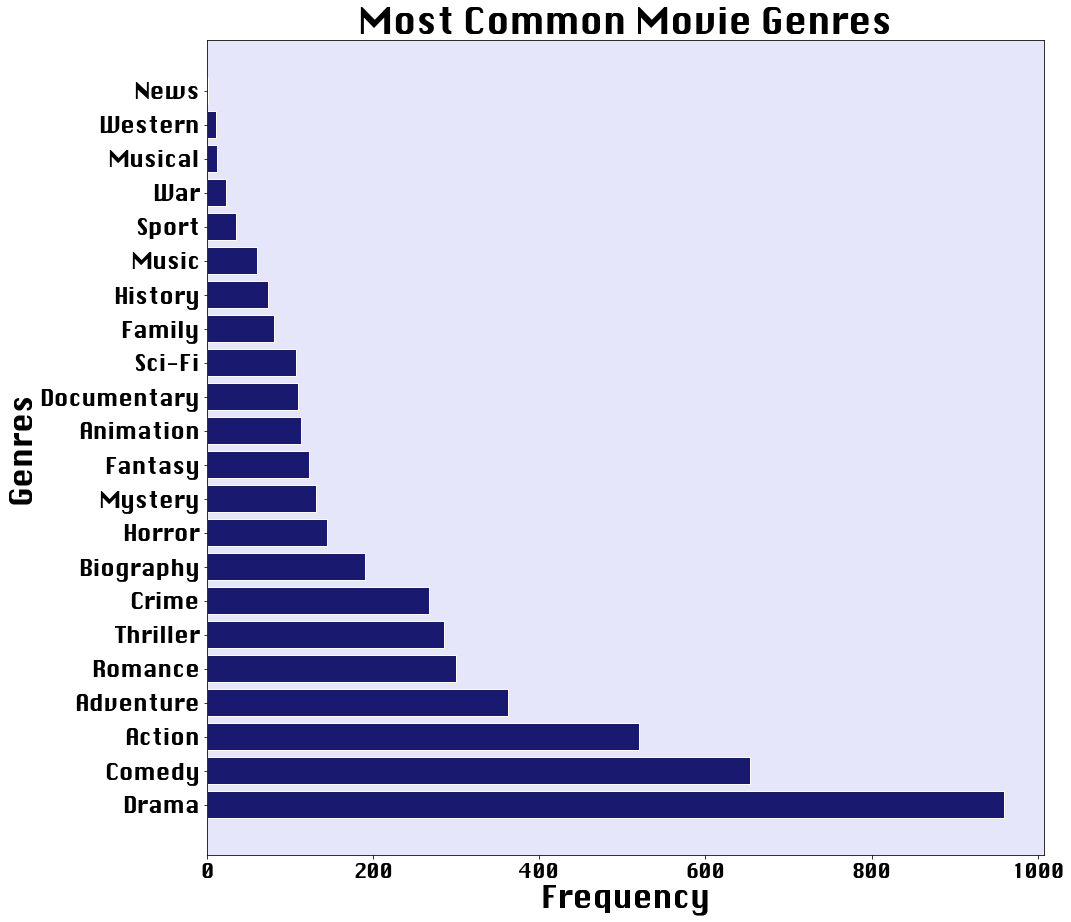

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.facecolor'] = 'lavender'
#create a figure with large width to display all genres clearly
plt.figure(figsize = (15,15))


#make a bar plot on the figure
plt.barh(x, y, color = 'midnightblue', edgecolor='1')

#label the axes, title, and ticks
plt.xlabel('Frequency', fontsize=30, fontname='Silom')
plt.ylabel('Genres', fontsize=30, fontname='Silom')
plt.xticks(fontsize=20, fontname='Silom')
plt.yticks(fontsize=22, fontname='Silom')
plt.title('Most Common Movie Genres', fontsize=35, fontname='Silom')

#display the plot
plt.show()

As this bar graph shows, drama, comedy, action and adventure are the most common genres. On the other end of the plot, we see that news, western, and musical films are quite rare. 

#### Rotten Tomatoes: What are the 'freshest' content ratings?
This sub-question will make use of the Rotten Tomatoes dictionaries created earlier to explore the distribution of 'fresh' and 'rotten' reviews for each content rating. Let's convert the list to a dataframe to make it more readable.

In [34]:
RT_Fresh_df = df = pd.DataFrame(RT_Fresh)
RT_Fresh_df

,rating,Fresh,Rotten
0,R,15561,8810
1,PG,5286,2960
2,PG-13,9303,8705
3,G,774,297
4,NR,2045,605


To convert the above numbers into percentages for easy comparison, we'll sum the reviews, divide 'fresh' and 'rotten' reviews by the sum, and muliply each by 100. We'll round these numbers to ensure that the percentages add up to 100 in each row.

In [35]:
for i in range(len(RT_Fresh_df)):
    total =  RT_Fresh_df['Fresh'][i] + RT_Fresh_df['Rotten'][i]
    RT_Fresh_df['Fresh'][i] = round((RT_Fresh_df['Fresh'][i]/total)*100, 0)
    RT_Fresh_df['Rotten'][i] = round((RT_Fresh_df['Rotten'][i]/total)*100, 0)
RT_Fresh_df

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,rating,Fresh,Rotten
0,R,64,36
1,PG,64,36
2,PG-13,52,48
3,G,72,28
4,NR,77,23


Finally, we'll sort these rows from highest to lowest 'fresh' rating percentages, and plot the review categories side-by-side on a bar graph.  

In [36]:
#sort by fresh ratings
q = """select * from RT_Fresh_df order by Fresh desc;"""
RT_Fresh_df = pd.DataFrame(pysqldf(q))

Text(0, 0.5, 'Percentage of Reviews')

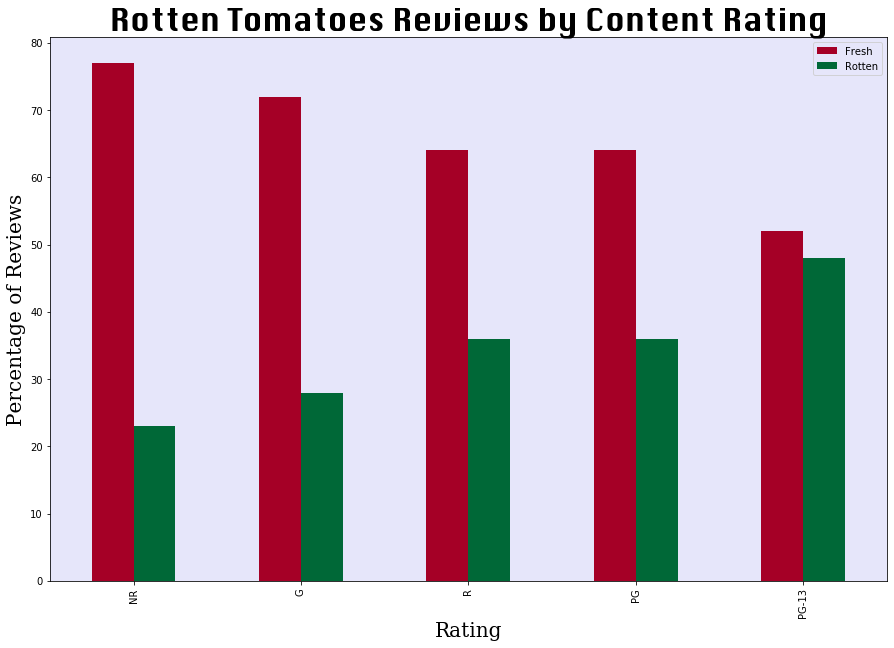

In [37]:
#set plot background color
plt.rcParams['axes.facecolor'] = 'lavender'

#plot df
ax = RT_Fresh_df.plot(figsize=(15,10),kind='bar', x = 'rating', colormap='RdYlGn')

#set title and axes labels
ax.set_title("Rotten Tomatoes Reviews by Content Rating", fontname='Silom', fontsize=30)
ax.set_xlabel('Rating', fontname='serif', fontsize=20)
ax.set_ylabel("Percentage of Reviews", fontname='serif', fontsize=20)

Unrated and G-rated movies have the highest percentage of fresh reviews. For all content rating categories, the percentage of fresh reviews exceeds that of the rotten reviews. For PG-13 films, however, the percentage of fresh and rotten reviews are closer together than for films of any other content rating.

### Question 2: What are the highest-grossing movie genres?
To answer this question, we will need to group films of the same genre together and arrange them in descending order by their domestic gross values.

In [38]:
#query to get the gross and genres columns, 
#group the genres together, 
#and arrange them from highest to lowest domestic gross 

q = """select title, domestic_gross, genres from IMBD_df group by genres order by domestic_gross desc;"""

#create a data frame from the query output and assign it to 'dom_gross_df'
dom_gross_df = pd.DataFrame(pysqldf(q))

#preview new dataframe
dom_gross_df

,title,domestic_gross,genres
0,Toy Story 3,415000000.0,"Adventure,Animation,Comedy"
1,The Twilight Saga: Eclipse,300500000.0,"Adventure,Drama,Fantasy"
2,Inception,292600000.0,"Action,Adventure,Sci-Fi"
3,The Hobbit: The Desolation of Smaug,258399999.0,"Adventure,Fantasy"
4,The Hangover Part II,254500000.0,"Comedy,Mystery"
...,...,...,...
257,Universal Soldier: Day of Reckoning,5500.0,"Action,Horror,Mystery"
258,Flypaper,5000.0,"Comedy,Crime,Mystery"
259,As Good as Dead,2000.0,"Crime,Thriller"
260,Open Windows,1800.0,"Crime,Horror,Thriller"


This dataframe has only the variables we are interested in, arranged by genre combination and domestic gross values. However, as with the last question, we want to calculate the domestic gross values for each *individual* genre to see which are the highest-grossing. 

We'll first calculate the total gross sums, then calculate the average gross values, for each genre. The first step is to make a list of all the unique genres.

In [39]:
genre_lists = []
for row in dom_gross_df['genres']:
    row = row.split(",")
    genre_lists.append(row)

Now let's set the 'genres' column equal to this list, and preview it:

In [40]:
dom_gross_df['genres'] = genre_lists
dom_gross_df['genres'][0:5]

0    [Adventure, Animation, Comedy]
1       [Adventure, Drama, Fantasy]
2       [Action, Adventure, Sci-Fi]
3              [Adventure, Fantasy]
4                 [Comedy, Mystery]
Name: genres, dtype: object

Great! We'll now make a column for each genre:

In [41]:
for genre in genres:
    dom_gross_df[genre] = 0
dom_gross_df.head()

,title,domestic_gross,genres,Adventure,Animation,Comedy,Action,Sci-Fi,Drama,Fantasy,...,Horror,Mystery,Western,Crime,Sport,War,Music,Musical,Documentary,News
0,Toy Story 3,415000000.0,"[Adventure, Animation, Comedy]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Twilight Saga: Eclipse,300500000.0,"[Adventure, Drama, Fantasy]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Inception,292600000.0,"[Action, Adventure, Sci-Fi]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Hobbit: The Desolation of Smaug,258399999.0,"[Adventure, Fantasy]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Hangover Part II,254500000.0,"[Comedy, Mystery]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The below function will take a genre column from the dataframe, and create a list of calculated gross values for each row. Later, we can sum these values to get the total gross amount for each genre.

In [42]:
def calculate_genre_gross(column):
    
    #list of gross values
    genre_gross = []
    
    #iterate through each row
    for i in range(len(dom_gross_df)):
        
        #specify only those rows where the column's genre appears in the genre list 
        if column in dom_gross_df['genres'][i]:
            
            #divide total dom gross by number of genres in the list
            dom_gross_df[column][i] = dom_gross_df['domestic_gross'][i]/len(dom_gross_df['genres'][i])
        
        #update the genre_gross list with the values for each row, and return it   
        genre_gross.append(dom_gross_df[column][i])
    return genre_gross

Now let's write a for loop to apply this function to every individual genre column in the dataframe.

In [43]:
for genre in genres:
    dom_gross_df[genre] = calculate_genre_gross(genre)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


This preview of the updated dataframe shows that the results match our expectations:

In [44]:
dom_gross_df.head()

,title,domestic_gross,genres,Adventure,Animation,Comedy,Action,Sci-Fi,Drama,Fantasy,...,Horror,Mystery,Western,Crime,Sport,War,Music,Musical,Documentary,News
0,Toy Story 3,415000000.0,"[Adventure, Animation, Comedy]",138333333,138333333,138333333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Twilight Saga: Eclipse,300500000.0,"[Adventure, Drama, Fantasy]",100166666,0,0,0,0,100166666,100166666,...,0,0,0,0,0,0,0,0,0,0
2,Inception,292600000.0,"[Action, Adventure, Sci-Fi]",97533333,0,0,97533333,97533333,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Hobbit: The Desolation of Smaug,258399999.0,"[Adventure, Fantasy]",129199999,0,0,0,0,0,129199999,...,0,0,0,0,0,0,0,0,0,0
4,The Hangover Part II,254500000.0,"[Comedy, Mystery]",0,0,127250000,0,0,0,0,...,0,127250000,0,0,0,0,0,0,0,0


Below, we make a dictionary with the sum totals for each genre, and then arrange the sums in descending order:

In [45]:
#create and populate dictionary
sum_dict = {}
for genre in genres:
    sum_dict[genre] = sum(dom_gross_df[genre])

#sort from highest to lowest sums 
Total_Gross = dict(sorted(sum_dict.items(), key=operator.itemgetter(1),reverse=True))
Total_Gross = pd.DataFrame.from_dict(Total_Gross, orient='index')

#set column names for Total Gross df
Total_Gross.reset_index(drop=False, inplace=True)
Total_Gross.rename(columns={"index": "Genre", 0: "Total_Gross"}, inplace=True)

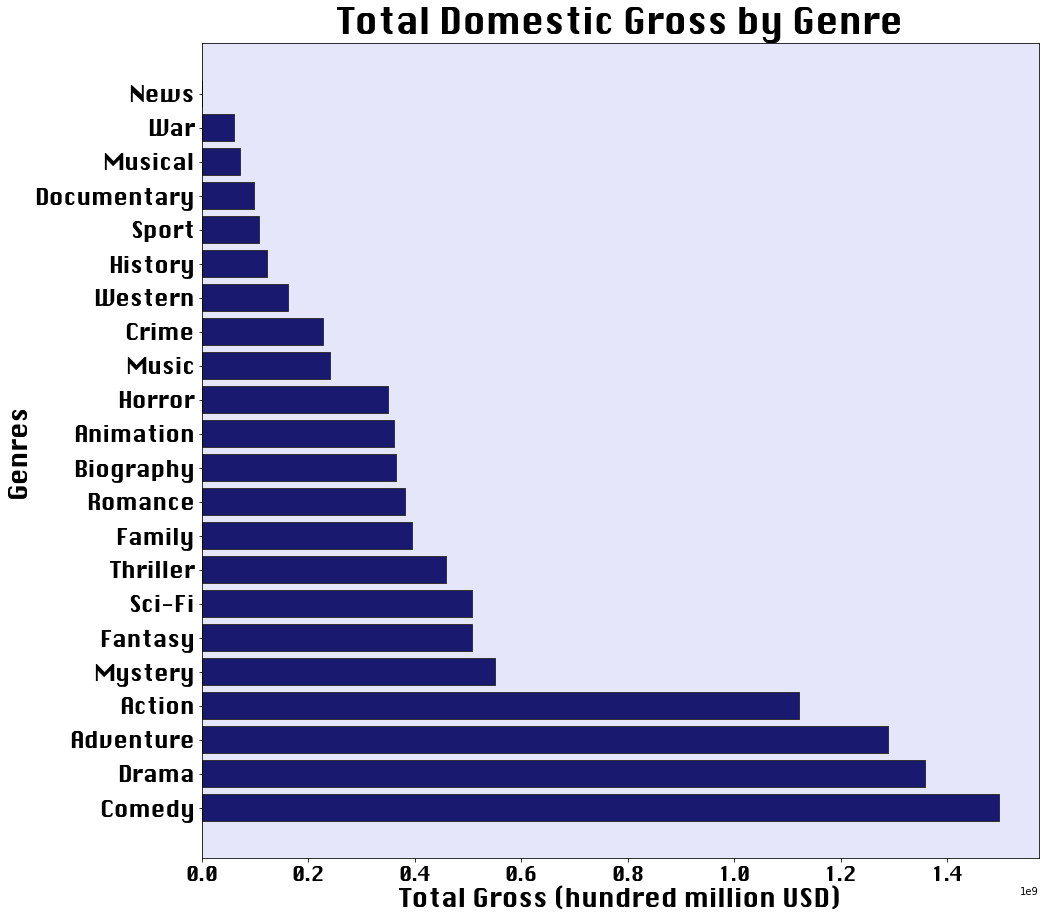

In [46]:
x = list(Total_Gross['Genre'])
y = list(Total_Gross['Total_Gross'])

plt.figure(figsize = (15,15))

plt.barh(x, y, color = 'midnightblue', edgecolor='0.2')

plt.xlabel('Total Gross (hundred million USD)', fontsize=25, fontname='Silom')
plt.ylabel('Genres', fontsize=25, fontname='Silom')
plt.xticks(fontsize=20, fontname='Silom')
plt.yticks(fontsize=22, fontname='Silom')
plt.title('Total Domestic Gross by Genre', fontsize=35, fontname='Silom')

#display the plot
plt.show()


This graph looks quite similar to the graph of genre frequencies. This makes sense: genres that are more common would be expected to have gross higher sums than rare genres. In this graph, however, comedy beats drama and adventure beats action. Mystery, sci-fi, and fantasy have all moved up to one of the top positions in the graph! These differences can be explained by differences in average gross values, which we’ll take a look at now.

To calculate the averages, we'll "explode" the domestic gross data frame, which will turn each genre in each list under “genres” into a distinct row, and hold all other row values constant. Then, we'll group the data by genres and call the “describe” function to generate descriptive statistics for the domestic gross column. Finally, we'll  filter the data to include only the mean values and genres, and ordered it from the highest to lowest means:

In [47]:
Avg_Gross_exploded = dom_gross_df.explode('genres')
Avg_Gross_grouped = Avg_Gross_exploded.groupby('genres').describe()['domestic_gross']

In [48]:
q = """select genres, count, mean from Avg_Gross_grouped order by mean DESC;"""
Avg_Gross_df = pysqldf(q)
Avg_Gross_df

,genres,count,mean
0,Adventure,47.0,7.833881e+07
1,Animation,19.0,5.711614e+07
2,Sci-Fi,26.0,5.558522e+07
3,Family,22.0,5.311770e+07
4,Comedy,74.0,4.953362e+07
5,Action,67.0,4.850222e+07
6,Western,8.0,4.808139e+07
7,Mystery,33.0,4.360373e+07
8,Fantasy,33.0,4.150895e+07
9,Music,16.0,3.593779e+07


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Gross Values by Genre')

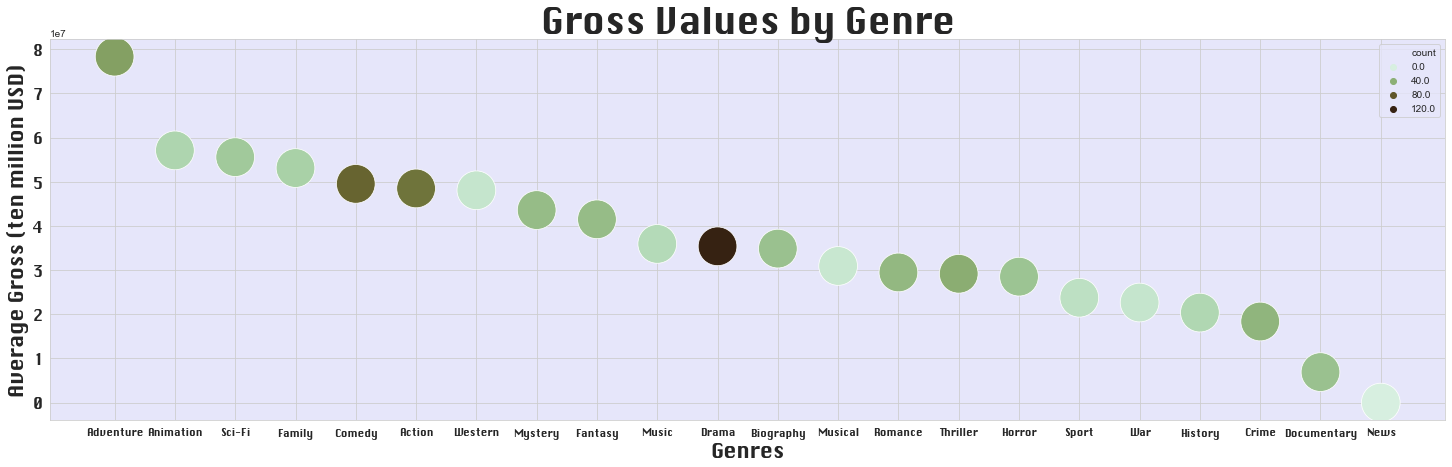

In [49]:
import seaborn as sns

#set figure properties
plt.figure(figsize=(25,7))
sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = 'lavender'

#create color range for markers
cmap = sns.cubehelix_palette(start=1, light=.9, as_cmap=True)

#plot average gross values, with size and hue varying by total values
ax = sns.scatterplot(x="genres", y="mean",
                     hue="count", palette=cmap, data=Avg_Gross_df, s=1500) 

#set properties for ticks and labels
plt.xticks(fontsize=10, fontname='Silom')
plt.yticks(fontsize=15, fontname='Silom')
plt.xlabel('Genres', fontsize=20, fontname='Silom')
plt.ylabel('Average Gross (ten million USD)', fontsize=20, fontname='Silom')
plt.title('Gross Values by Genre', fontsize=35, fontname='Silom')

Animation, sci-fi and family were not among the most common genres. However, next to adventure, these are top-performing genres in terms of their average gross value. Western also stands out as being a very rare genre that nonetheless has a relatively high position on the y-axis. 

What if we're interested in comparing average and total gross values for only the top-grossing genres? Using <code>pysqldf</code>, let's subset the data into the top 5 genres and plot those. 

In [50]:
q = """select genres, mean from Avg_Gross_df DESC limit 5;"""
Top_Avg = pysqldf(q)

q = """select Genre, Total_Gross from Total_Gross limit 5;"""
Top_Total = pysqldf(q)

display(Top_Avg, Top_Total)

,genres,mean
0,Adventure,7.833881e+07
1,Animation,5.711614e+07
2,Sci-Fi,5.558522e+07
3,Family,5.311770e+07
4,Comedy,4.953362e+07


,Genre,Total_Gross
0,Comedy,1497329313
1,Drama,1359535655
2,Adventure,1289789335
3,Action,1121966898
4,Mystery,550951725


Text(0, 0.5, 'Average Gross (hundred millions)')

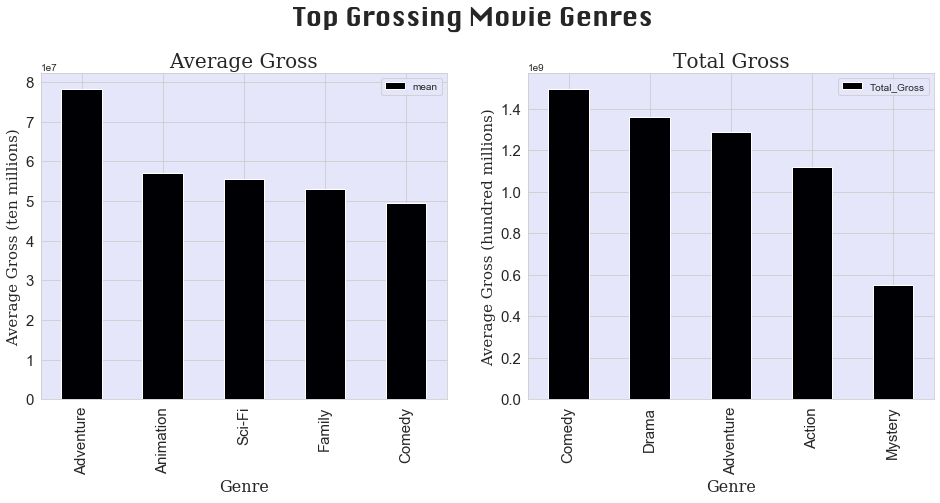

In [51]:
#create 2 subplots in a 1x2 figure
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

#set figure title
plt.figtext(.5,.99, 'Top Grossing Movie Genres', fontsize=25, fontname='silom', ha='center')

#plot data over the axes
Top_Avg.plot(ax = axes[0],subplots=True, fontsize = 15, kind='bar', x='genres', y='mean', colormap='magma') 
Top_Total.plot(ax = axes[1],subplots=True, fontsize = 15, kind='bar', x='Genre', y='Total_Gross', colormap='magma')

#set titles and labels for subplots
plt.rcParams['axes.facecolor'] = 'lavender'
axes[0].set_title("Average Gross", fontname='serif', fontsize=20)
axes[0].set_xlabel("Genre", fontsize=16, fontname='serif')
axes[0].set_ylabel("Average Gross (ten millions)", fontsize=15, fontname='serif')

axes[1].set_title("Total Gross", fontname='serif', fontsize=20)
axes[1].set_xlabel("Genre", fontsize=16, fontname='serif')
axes[1].set_ylabel("Average Gross (hundred millions)", fontsize=15, fontname='serif')

Looking at the graphs for the top 5 genres, we can see that adventure, animation, and sci-fi have the highest average gross values. Based on the genre frequency bar chart from the first question, we know that drama is among the most common genres, but it doesn't have a competitive average gross value. Its high total value is therefore attributable to its prevalence in the film industry. 

## Question 3: what is the ideal range for movie runtimes, in terms of profitability?
For our final question, we'll first make a subsetted dataframe with the movie runtimes and order the data from highest to lowest gross values. We'll filter out movies that aren't at least an hour long to focus on the performance of full-length films.

In [52]:
    q = '''select title, runtime_minutes, domestic_gross, genres from IMBD_df where runtime_minutes >= 60
           order by domestic_gross desc;'''
    runtime_df = pd.DataFrame(pysqldf(q))
runtime_df

,title,runtime_minutes,domestic_gross,genres
0,Black Panther,134.0,700100000.0,"Action,Adventure,Sci-Fi"
1,Avengers: Infinity War,149.0,678800000.0,"Action,Adventure,Sci-Fi"
2,Jurassic World,124.0,652300000.0,"Action,Adventure,Sci-Fi"
3,Star Wars: The Last Jedi,152.0,620200000.0,"Action,Adventure,Fantasy"
4,Incredibles 2,118.0,608600000.0,"Action,Adventure,Animation"
...,...,...,...,...
1832,Khumba,85.0,1000.0,"Adventure,Animation,Family"
1833,I Spit on Your Grave 2,106.0,800.0,"Horror,Thriller"
1834,Amityville: The Awakening,85.0,700.0,"Horror,Thriller"
1835,2:22,98.0,400.0,Thriller


Now we'll make a linear model plot of the data, with runtime on the x-axis and gross on the y-axis. We'll set <code>fit_reg=True</code>, which will plot an estimated regression model over the datapoints. 

Text(0.5, 1, 'Runtimes and Gross Values')

<Figure size 1080x1440 with 0 Axes>

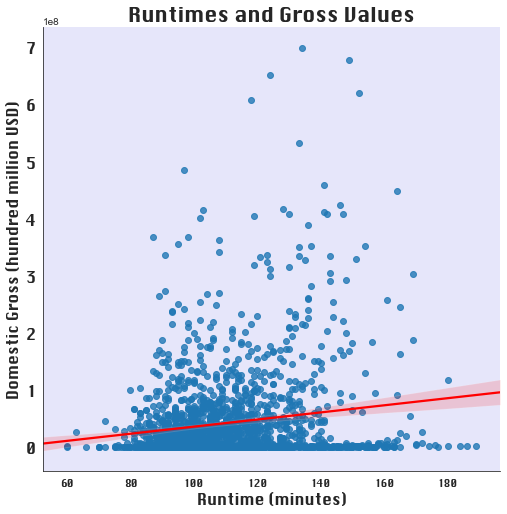

In [53]:
#set figure properties
sns.set_style("white")
plt.figure(figsize=(15,20))

plt.rcParams['axes.facecolor'] = 'lavender'
#plot runtime data
sns.lmplot(data=runtime_df, x="runtime_minutes", y="domestic_gross",
                   fit_reg=True, line_kws={'color': 'red'}, height=7,aspect=1, legend=True)

#set ticks, labels, and title 
plt.xticks(fontsize=10, fontname='Silom')
plt.yticks(fontsize=15, fontname='Silom')
plt.xlabel('Runtime (minutes)', fontsize=15, fontname='Silom')
plt.ylabel('Domestic Gross (hundred million USD)', fontsize=15, fontname='Silom')
plt.title('Runtimes and Gross Values', fontsize=20, fontname='Silom')

The regression line makes it clear that the vast majority of films do not gross more than a hundred million USD. However, the few films that gross well above this amount appear to fall within the range of 100-150 minutes. Let's get the exact numbers on the distribution with the help of the <b>Numpy</b> module.

In [54]:
import numpy as np
rt = runtime_df['runtime_minutes'] 

What are the minimum and maximum runtimes? 

In [55]:
np.min(rt)

60.0

In [56]:
np.max(rt)

189.0

What are the mean and median runtimes?

In [57]:
np.mean(rt)

110.97713663581926

In [58]:
np.median(rt)

107.0

What values are are the 25th and 75th percentile? This will give us a range of numbers between which the majority of the runtime data falls.

In [59]:
np.percentile(rt, [25, 75])

array([ 97., 122.])

We'll now get these same numbers for the top 50 highest-grossing movies!

In [60]:
q = """select * from runtime_df order by domestic_gross DESC limit 50;"""
top_gross_runtime = pd.DataFrame(pysqldf(q))
top_rt = top_gross_runtime['runtime_minutes']

In [61]:
np.min(top_rt)

87.0

In [62]:
np.max(top_rt)

169.0

In [63]:
np.mean(top_rt)

126.94

In [64]:
np.median(top_rt)

131.5

In [65]:
np.percentile(top_rt, [25, 75])

array([110.5 , 141.75])

It appears that high-grossing movies tend to run longer than movies in general. We can visually compare these distributions with juxtaposed boxplots.

Text(0.5, 0, '')

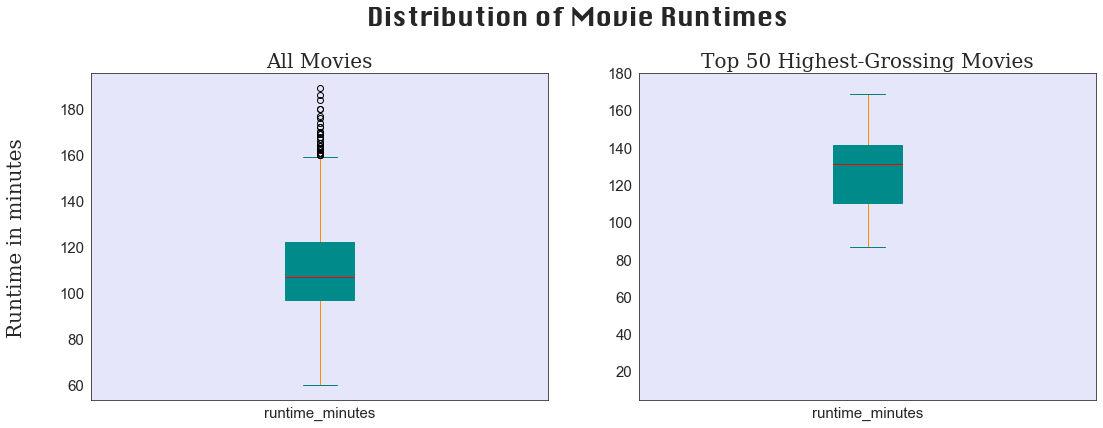

In [66]:
#set figure properties
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
plt.figtext(.5,.99, 'Distribution of Movie Runtimes', fontsize=25, fontname='silom', ha='center')
plt.rcParams['axes.facecolor'] = 'lavender'
plt.ylim(5, 180)
fig.text(0.06, 0.5, 'Runtime in minutes', va='center', rotation='vertical',fontsize=20, fontname='serif')

#set subplot properties
colors = dict(boxes="darkcyan", whiskers="darkorange", medians="red", caps="teal")
runtime_df.plot(ax = axes[0],subplots=True, fontsize = 15, 
                kind='box', y= 'runtime_minutes', color=colors, patch_artist=True) 

top_gross_runtime.plot(ax = axes[1],subplots=True, fontsize = 15, 
                       kind='box', y= 'runtime_minutes', color=colors, patch_artist=True)


axes[0].set_title("All Movies", fontname='serif', fontsize=20)
axes[1].set_title("Top 50 Highest-Grossing Movies", fontname='serif', fontsize=20)
axes[0].set_xlabel('')
axes[1].set_xlabel('')






These plots make it visually apparent that the highest-grossing films have relatively high runtimes compared to the average film. None of these high-grossing films, however, exceed 170 minutes.

# Recommendations Recap 

### Genres

Microsoft should create adventure, comedy, sci-fi and western films. Adventure and comedy films are both in the top 5 highest-grossing genres, in terms of both average and total gross numbers. Western and sci-fi films are more rare, but have highly competitive average gross values. 

### Content Ratings

The most well-reviewed films have either no rating or a G-Rating. Microsoft should make unrated and G-rated movies.

### Runtimes

Microsoft’s ideal runtime range is between 110 and 140 minutes. The average runtime for the highest-grossing films is just over 2 hours, which suggests that this may be the “sweet spot” for many audiences.

# References

[Visualization with Pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

[Seaborn plotting with Categorical Data](https://seaborn.pydata.org/tutorial/categorical.html)

[Pysqldf](https://pypi.org/project/pysqldf/)

[Maplotlib.pyplot.subplots](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplots.html)